## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import _pickle
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time
import os
import peakutils
from sklearn.mixture import GaussianMixture as GMM
import scipy


from ourfunctions_v3 import clean_nan_samples, remove_noise, interpolate_spectra, spectrum_in_bins_3

## Important Preprocessing parameters

In [2]:
m = 2000; M = 12000; 
bin_size = 5
step_size = 1; # interpolation step size

# path = "D:/GitHub/Machine-Learning/Kaggle/"
path = 'C:/Users/Javi/Documents/GitHub/Machine-Learning/Kaggle/'

## Load and clean data

In [3]:
savepath = path + 'Kaggle classifiers/bin size 5/'
path_results = path + 'Kaggle_results/'

ncpu = os.cpu_count()
if (ncpu>2): njobs = ncpu - 2; 
else: njobs = 1;
    
zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
df_train = _pickle.loads(zf.open('TrainData.pkl').read())
zf.close()

zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read())
zf.close()

df_train = remove_noise(df_train)

Training sample 339  eliminated
Training sample 490  eliminated


## Divide data in test and train
Also binning spectrum, normalize and remove baseline.

In [4]:
# Extract data (spectra) and targets of the df_train set
data = df_train.iloc[:,-2:]
targets = df_train.iloc[:,1:-2]

# Then, split into a train and test_train set
data_train, data_test_train, targets_train, targets_test_train = train_test_split(data, targets, test_size=0.2, random_state=0) # split the data
print('Training samples: '+str(len(data_train))+' and test_train samples: ' + str(len(data_test_train)) )

# apply the bins to all spectra, so that our feature space becomes the same for all samples (make them regular, all the same)
spectrum_train = spectrum_in_bins_3(data_train,m,M,bin_size)
spectrum_test_train = spectrum_in_bins_3(data_test_train,m,M,bin_size)
print('Spectrum interpolated!')
# these spectrum_... are our X for training

Training samples: 411 and test_train samples: 103
Spectrum interpolated!


## Peak detection algorithms
We can consider different peak detection algorithms:
* Gaussian Mixture Model: although slower, it is supposedly more accurate and appropiate. When using a low count level, the algorithm is fast and detects most peaks. However, many times their mean is somehow displaced. This would need to be corrected by looking at the maximum value in the vicinity. On the other hand, when using a higher count level (smaller single sample value, and more elements in samples_vector), the algorithm takes much more time, and also BIC indicates much larger values of N_COMPONENTS than what it should, leading to detection of many false peaks.
* PeakUtils peak detection: this function is actually working pretty well, although I think it is based on thresholding. Nonetheless, with a threshold of 0.05, is detecting very accurately most peaks and not giving too many false positives.
* FindPeaksCWT is another option for peak detection, although more sensitive to window size. Yesterday, I found bin_size = 5 and window_width = 3 to be a good combination.

In any case, after finding the peaks in the mean spectra, a new set of features should be built by getting the values of each spectrum at those positions (or nearby, in the case of inaccurate GMM). This will lead to a much lower number of features, and therefore to faster, less noisy classification. Anyway, a feature reduction step should be implemented.

First of all, let's get the mean spectrum:

In [5]:
mean_spectrum = np.mean(spectrum_train.to_numpy(),axis=0)

### PeakUtils

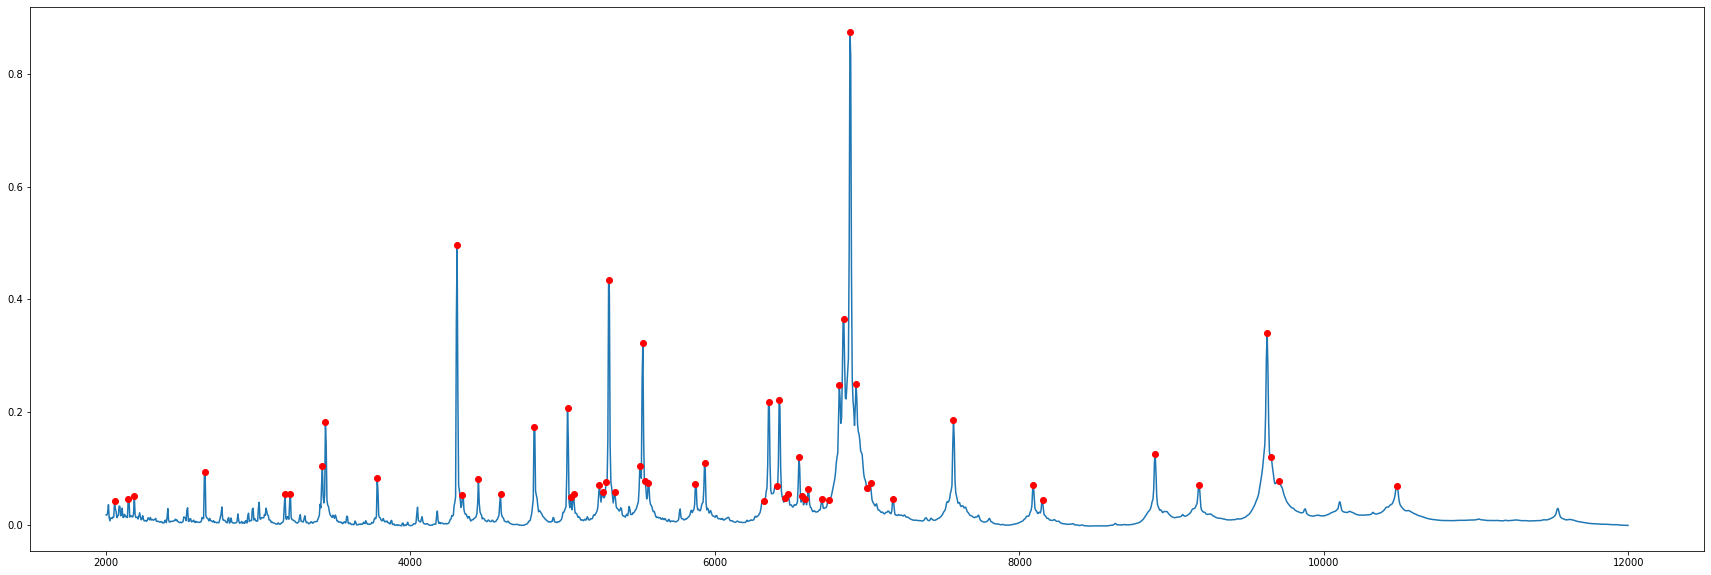

In [8]:
peaks = peakutils.peak.indexes(mean_spectrum,thres=0.05)

plt.figure(figsize=(30,10))
mz_axis = spectrum_train.columns.values
plt.plot(mz_axis,mean_spectrum)
plt.plot(mz_axis[peaks],mean_spectrum[peaks],'ro')
plt.show()

In [7]:
def spectrum_in_peaks(spectrum,peaks):
    df = spectrum.copy()
    spectrum  = spectrum.to_numpy()
    new_spectrum = np.zeros((spectrum.shape[0],len(peaks)))
    
    for i,x in enumerate(spectrum):
      spectrum_train_aux = x[peaks]
      new_spectrum[i,:] = spectrum_train_aux

    new_df = pd.DataFrame(data=new_spectrum, columns = df.columns.values[peaks], index = df.index)
    return new_df

peaks_spectrum_train = spectrum_in_peaks(spectrum_train,peaks)

## Denoising
Let's investingate polynomial filtering for denoising. If it works well, include it in spectrum_in_bins.

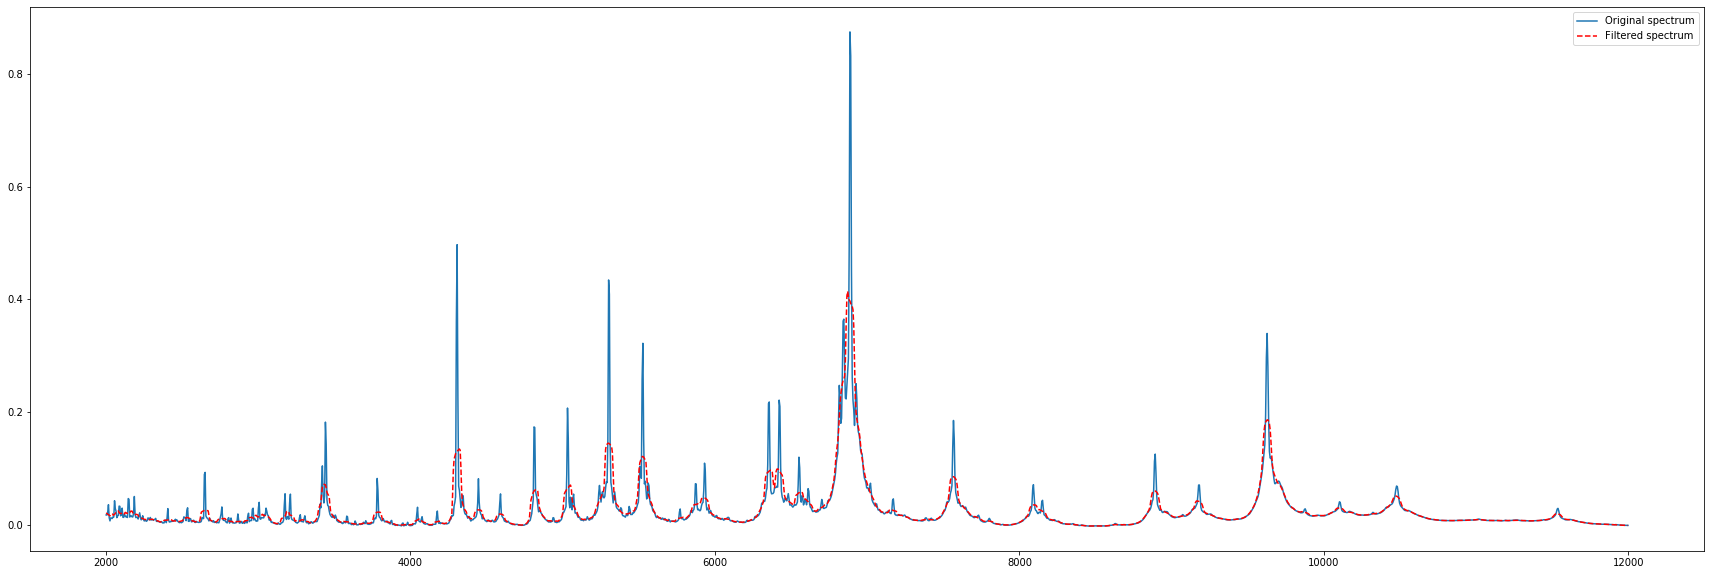

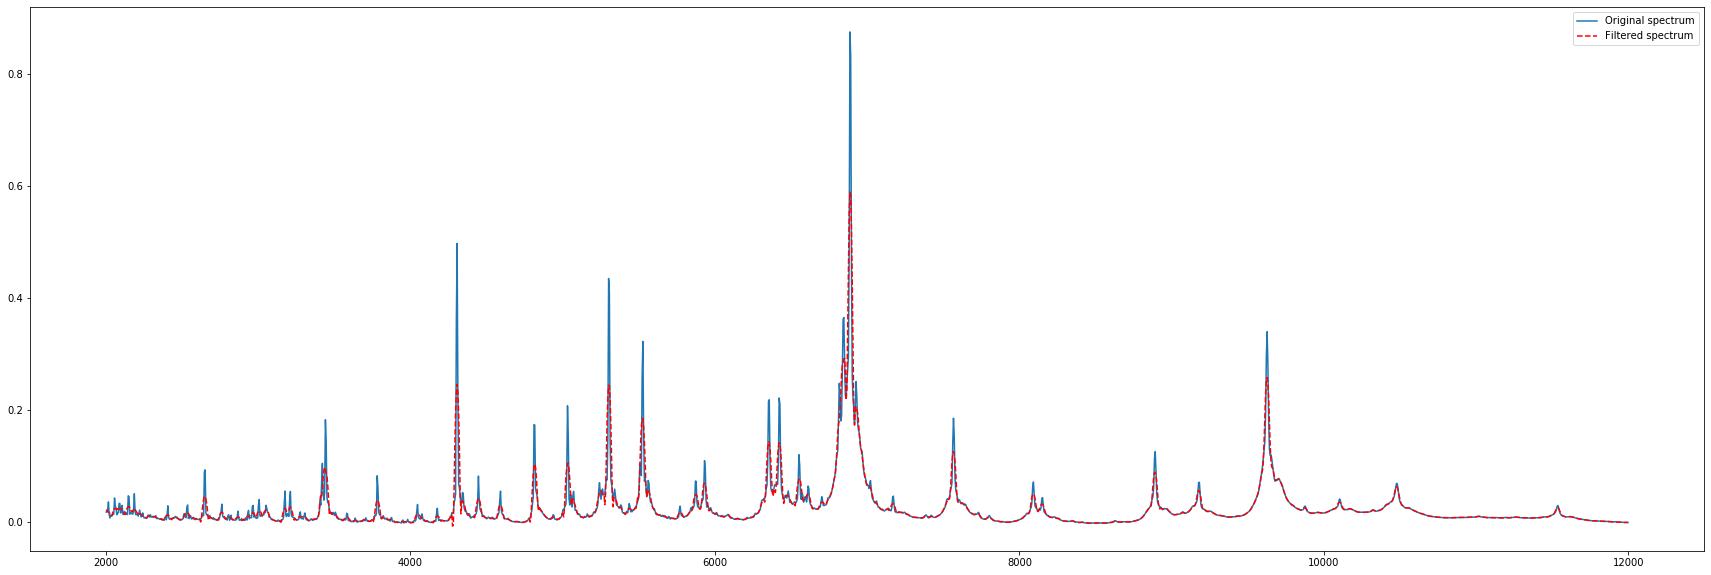

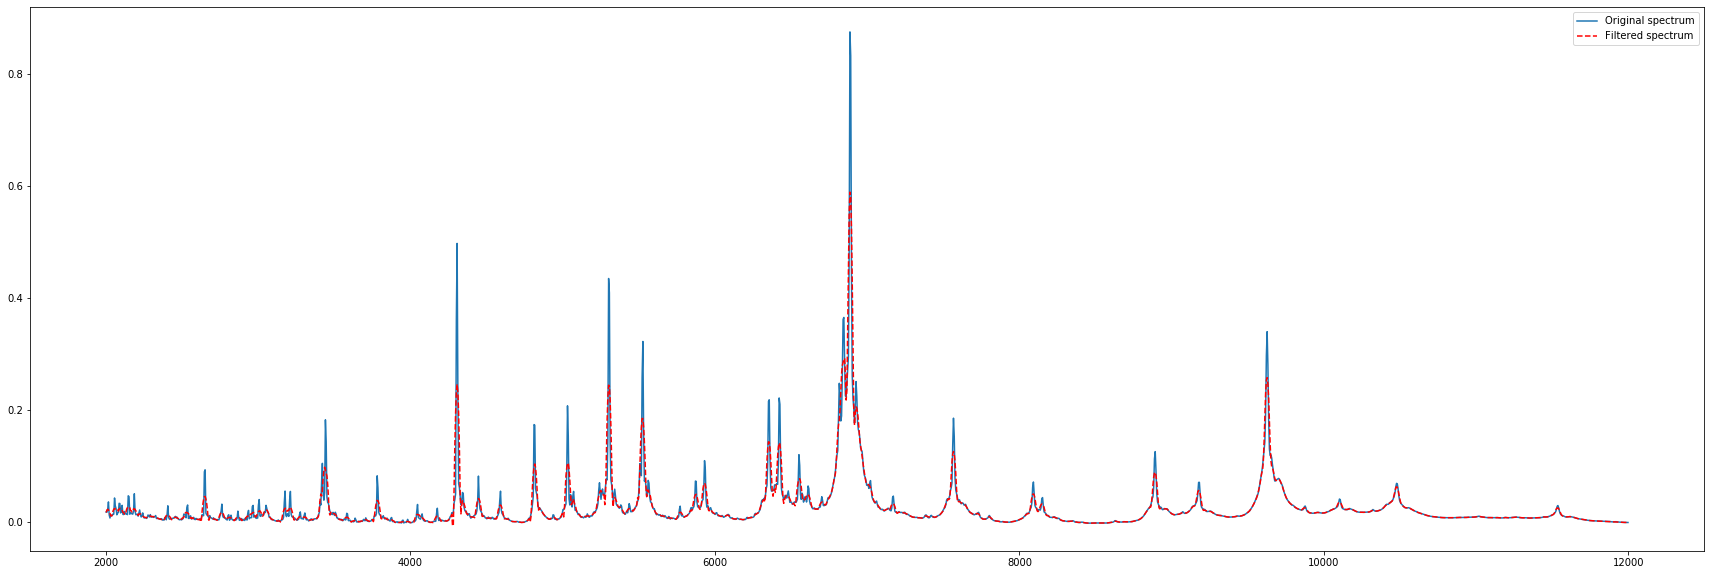

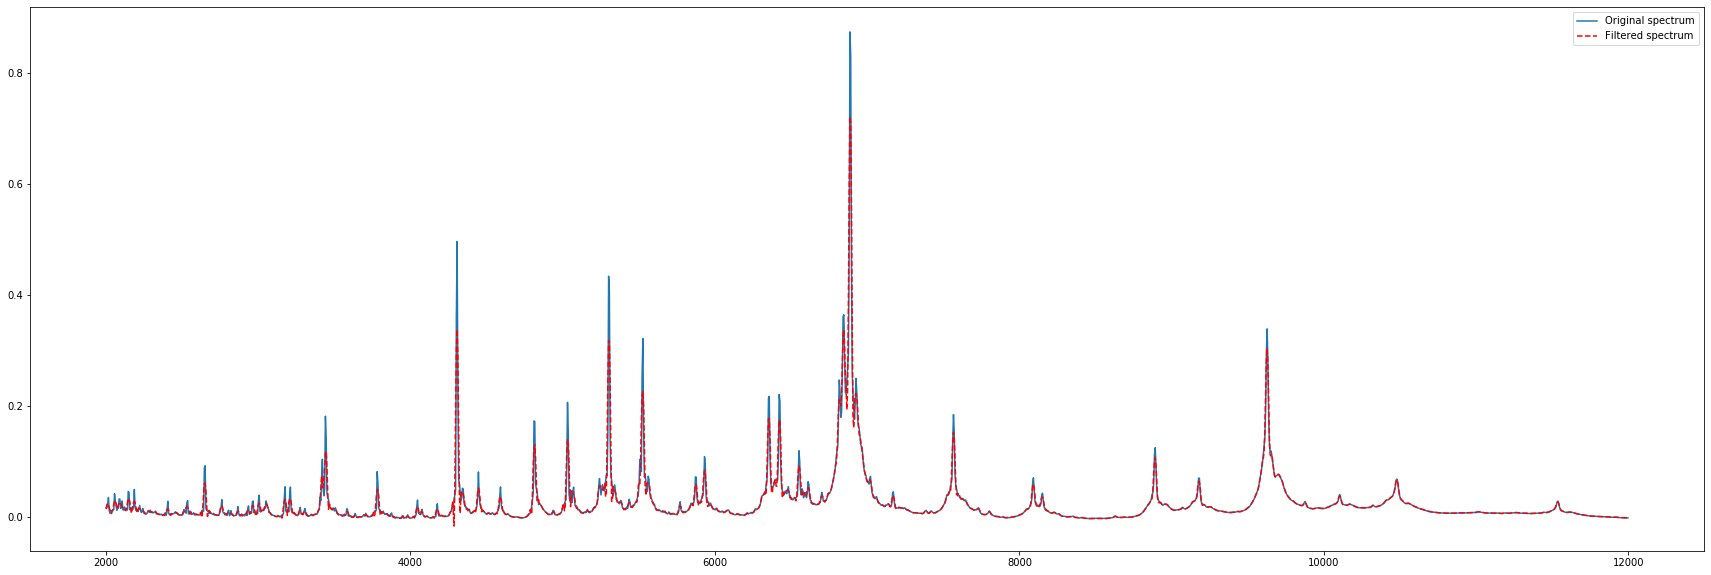

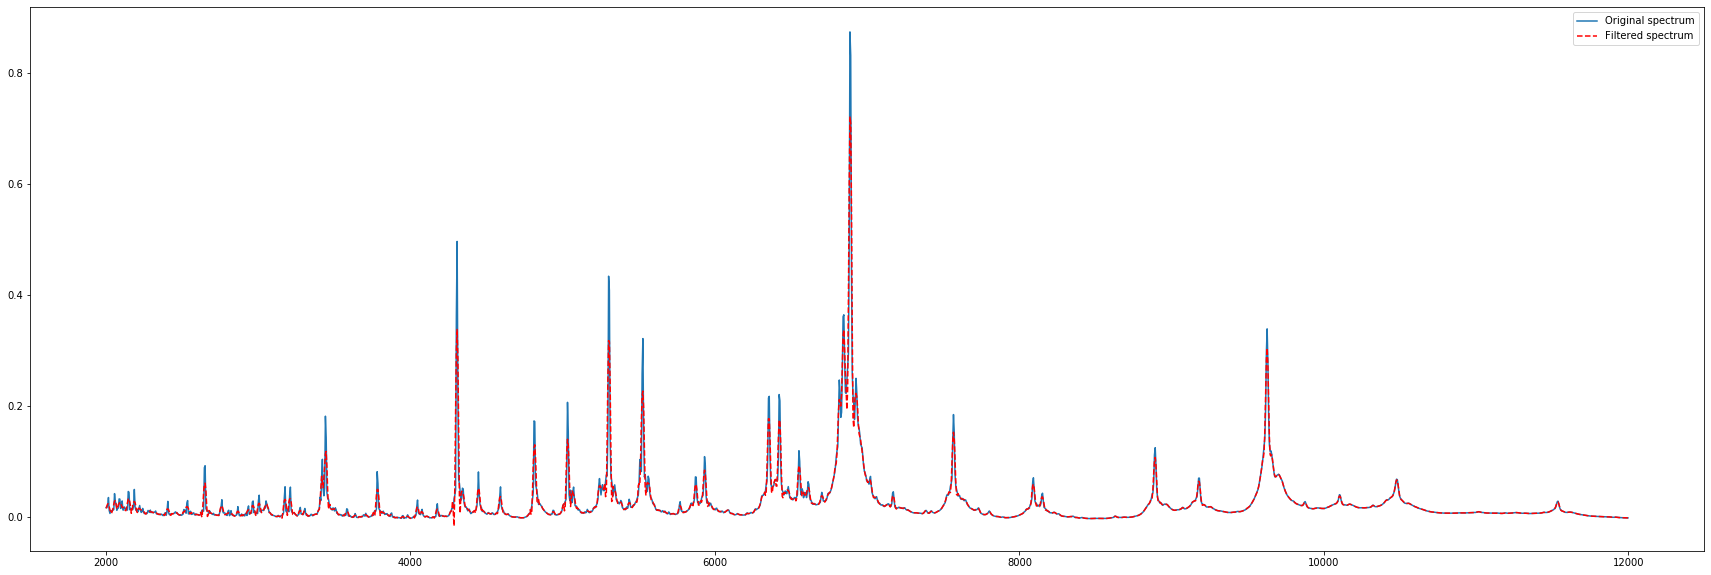

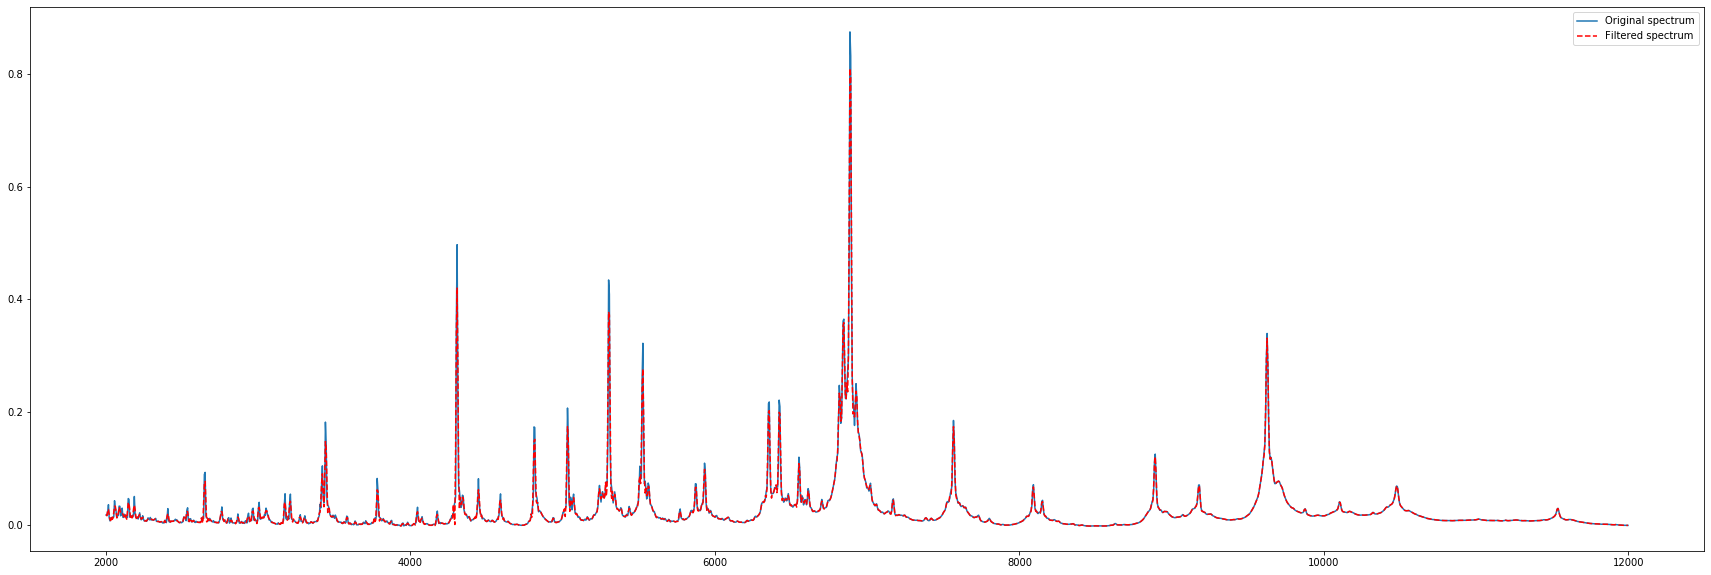

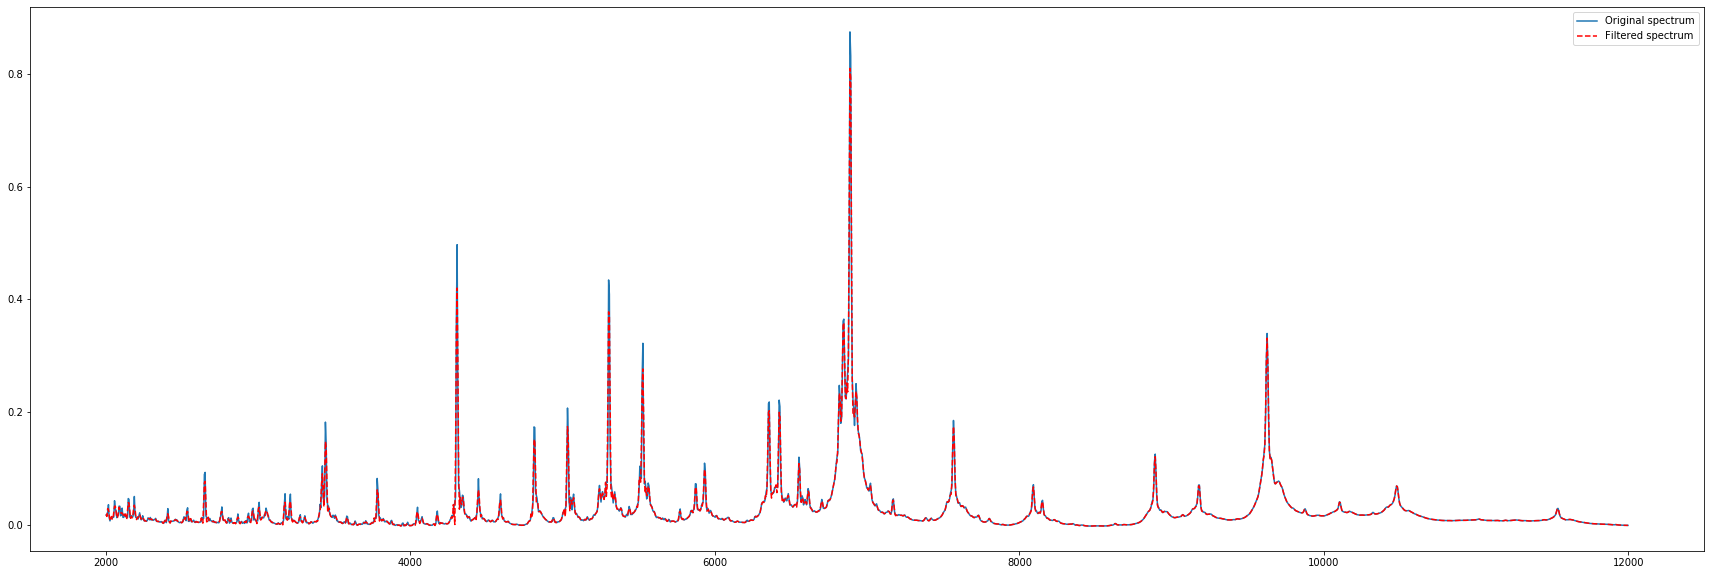

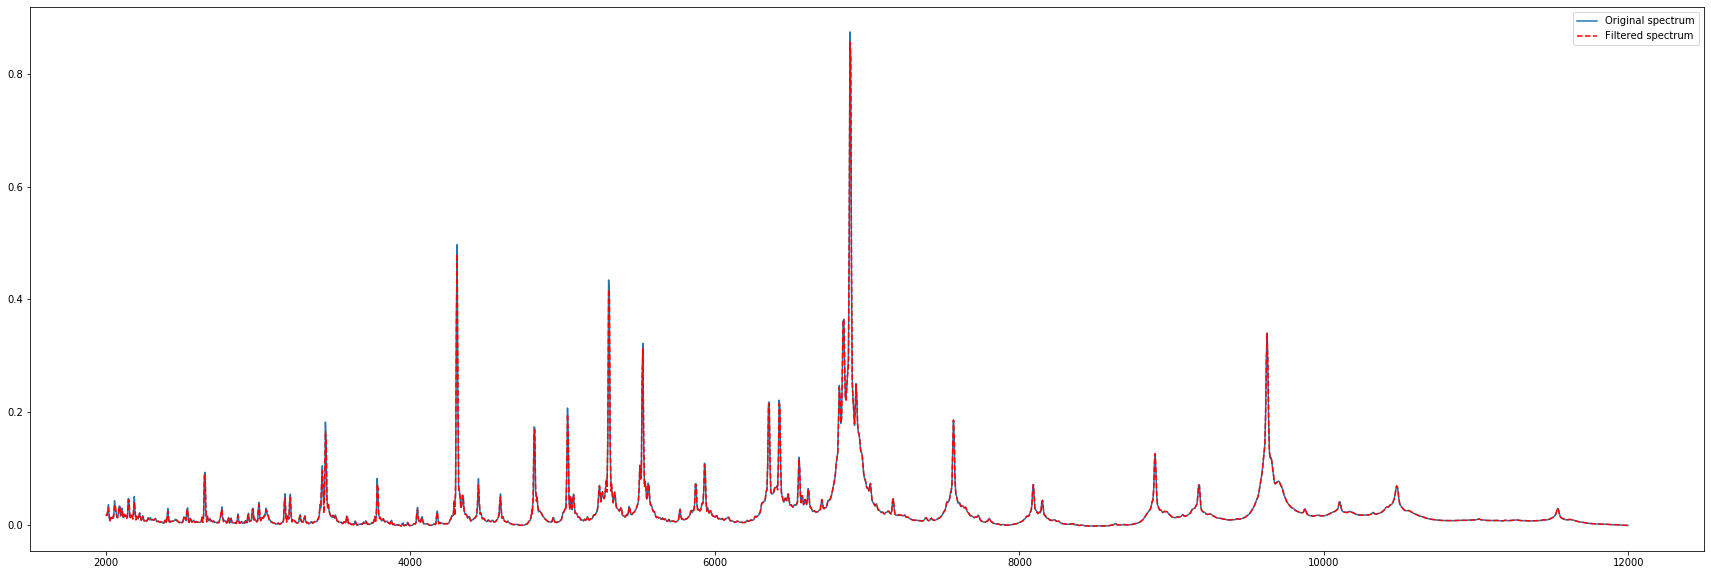

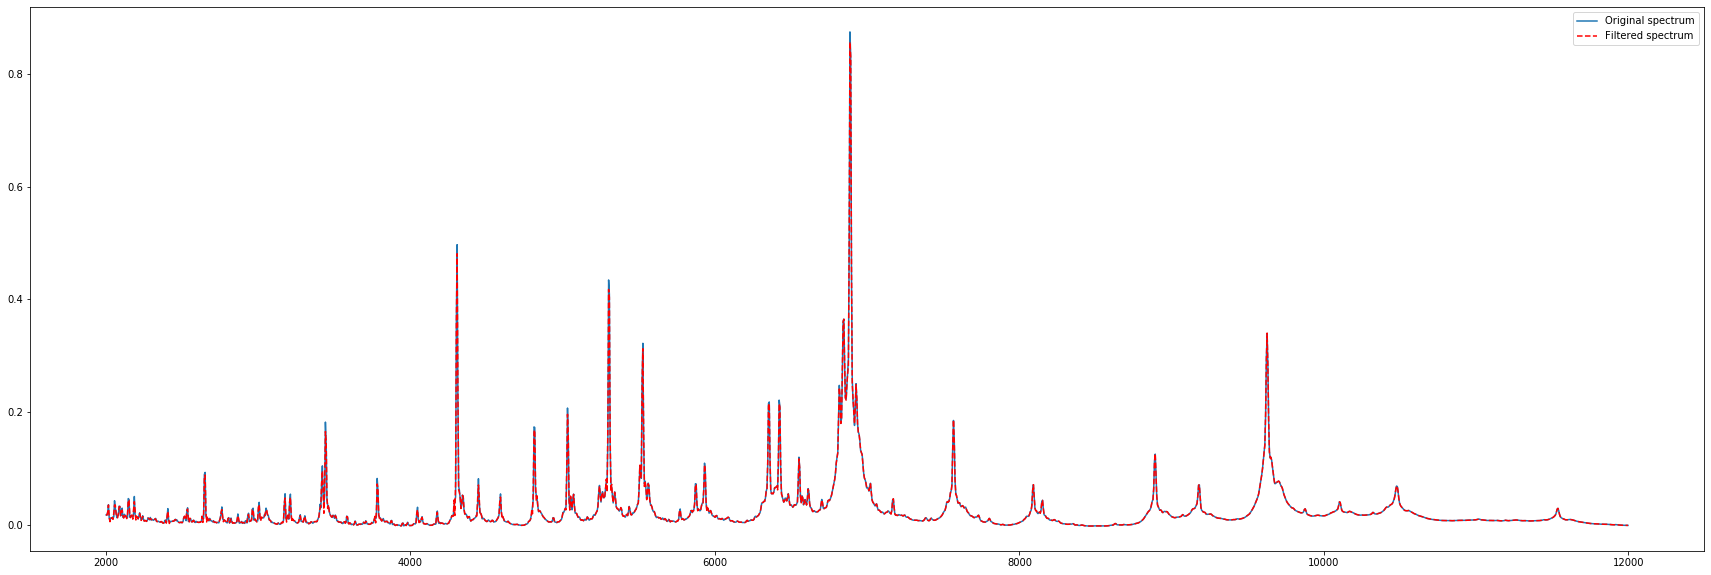

In [15]:
from scipy.signal import savgol_filter

for i in np.arange(1,10):
    filt_spectrum = savgol_filter(mean_spectrum,window_length=11,polyorder=i)
    plt.figure(figsize=(30,10))
    plt.plot(mz_axis,mean_spectrum,label='Original spectrum')
    plt.plot(mz_axis,filt_spectrum,'r--',label='Filtered spectrum'); plt.legend(); plt.show()

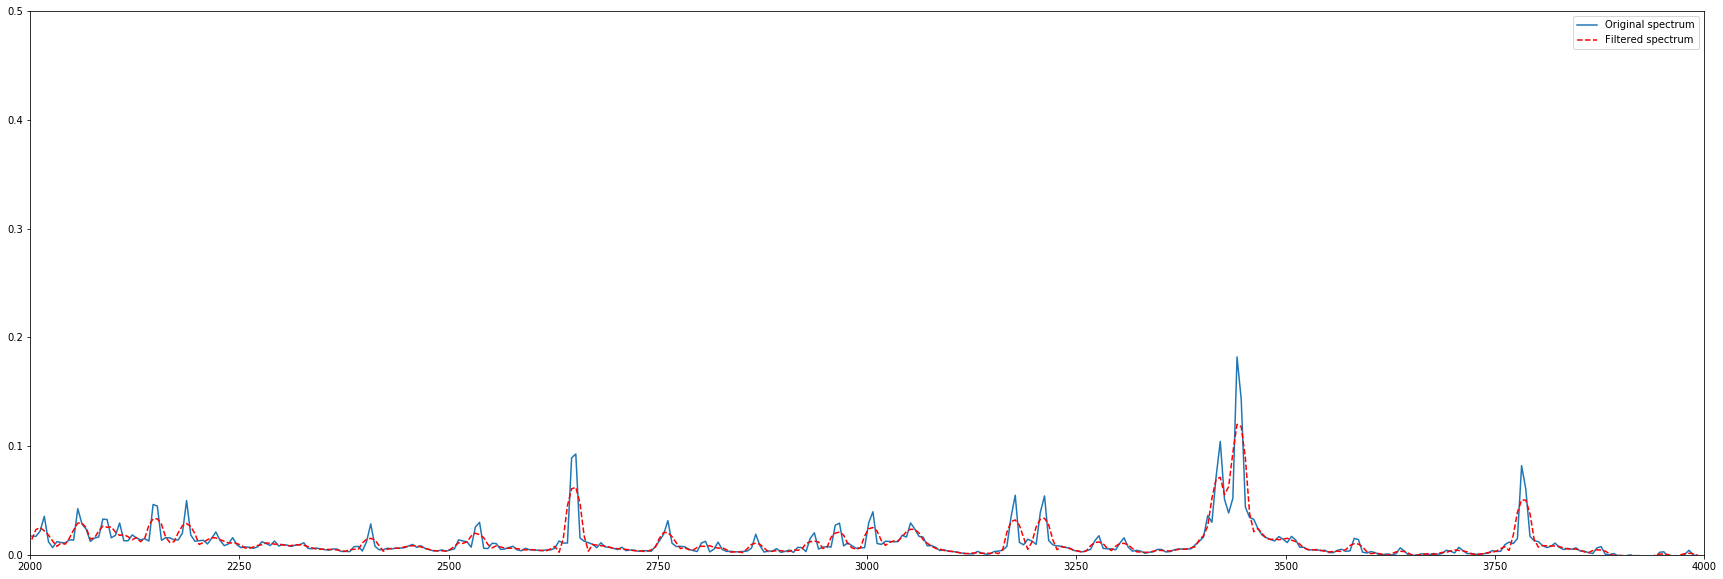

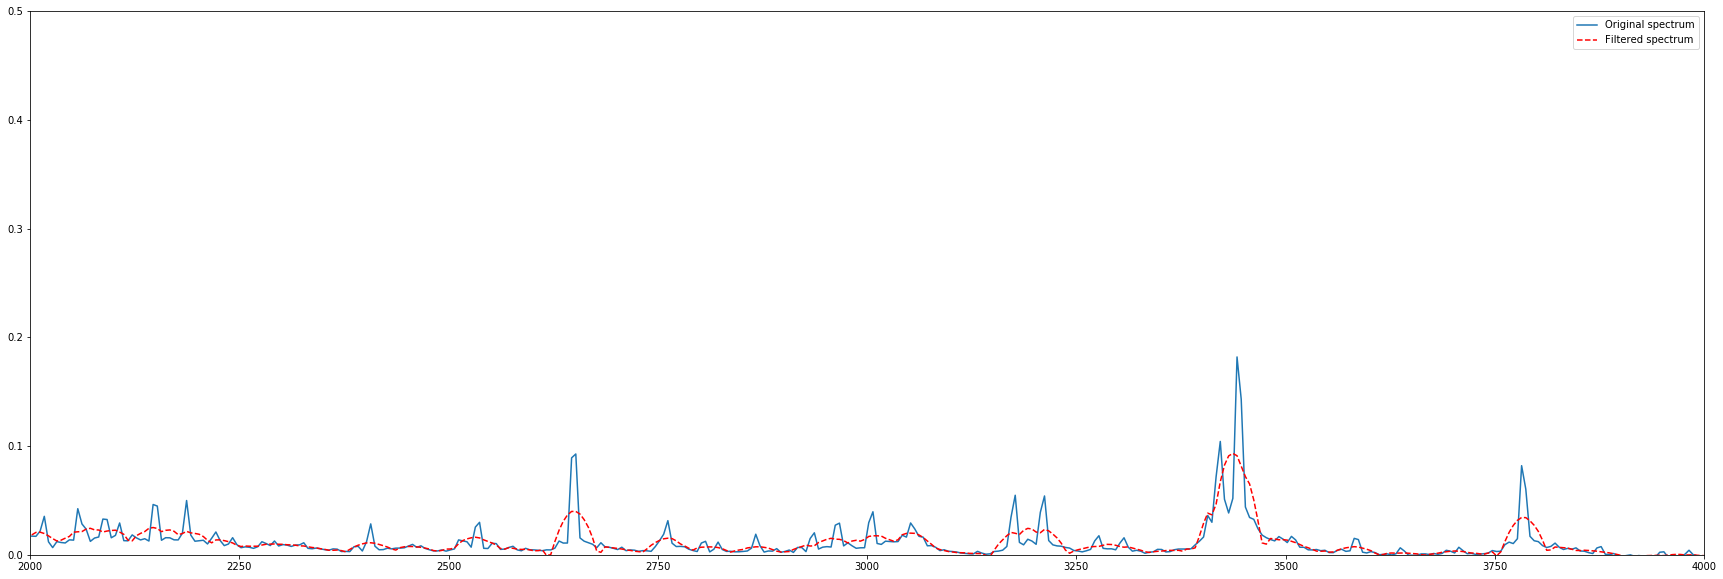

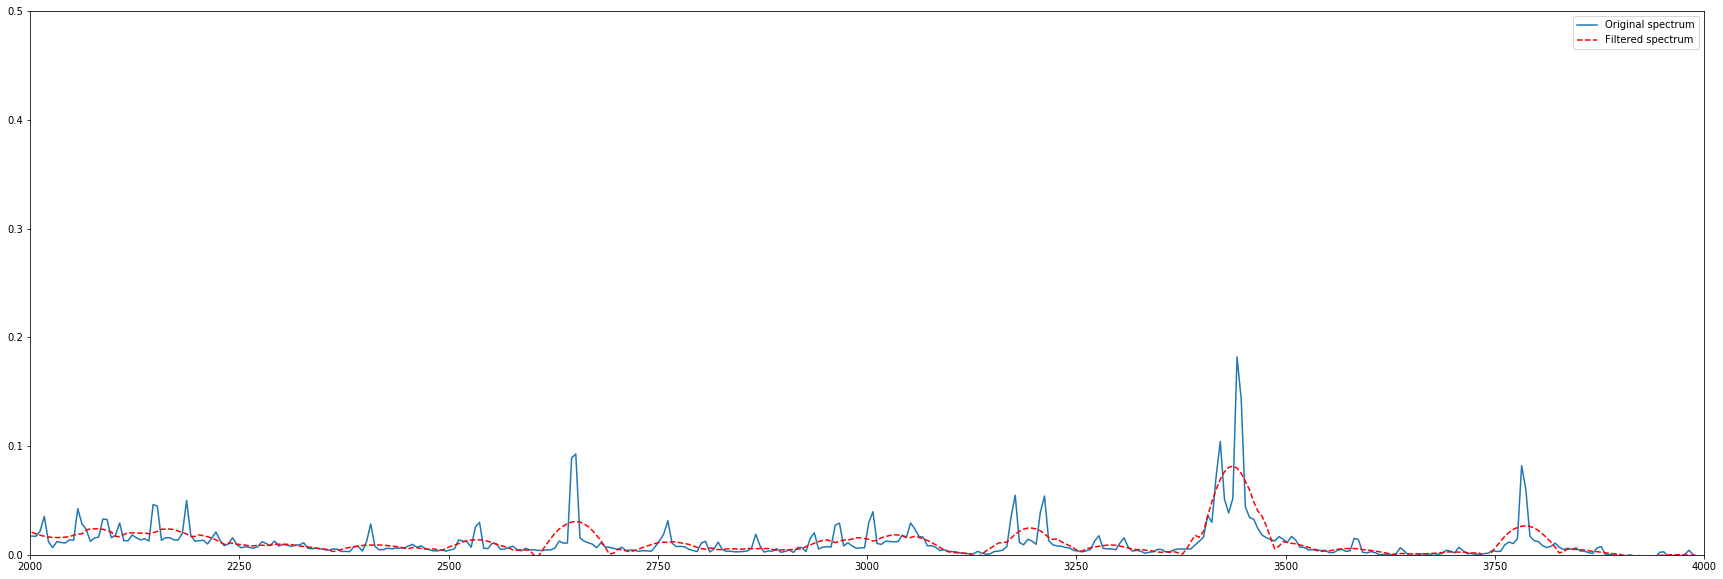

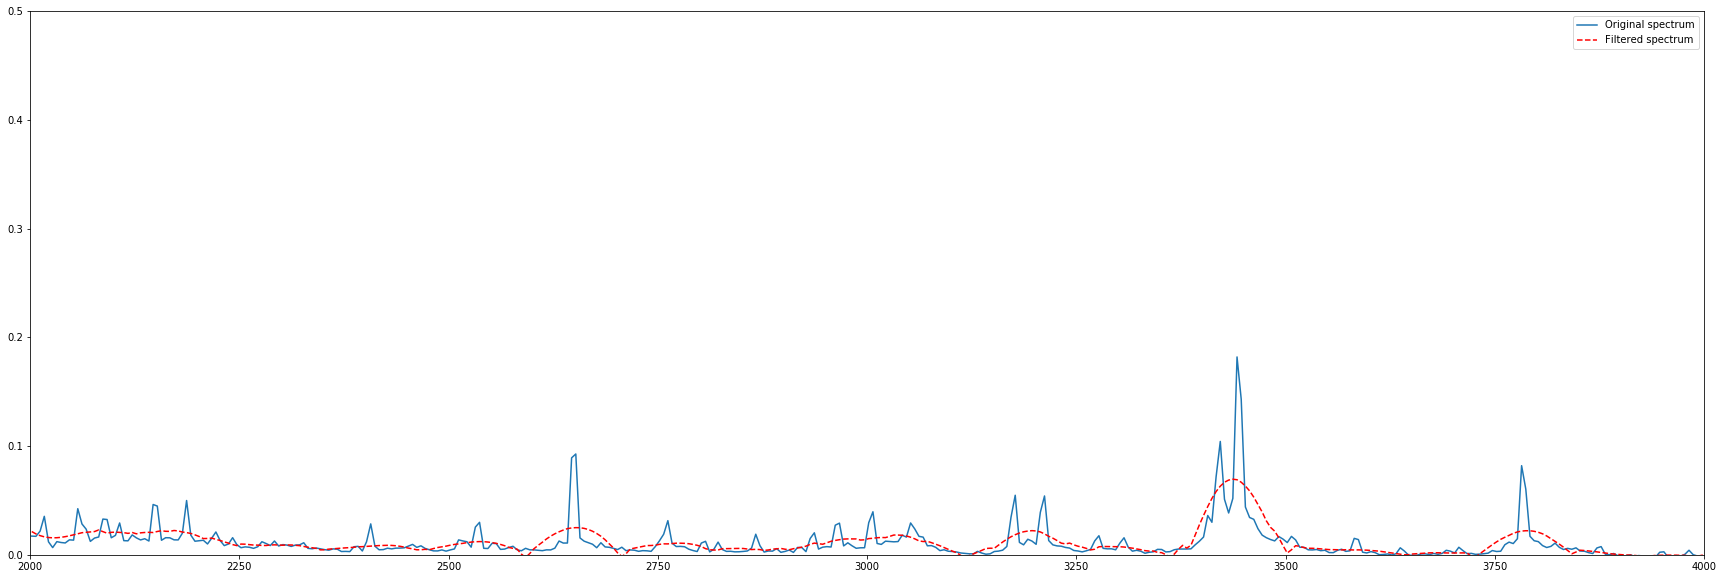

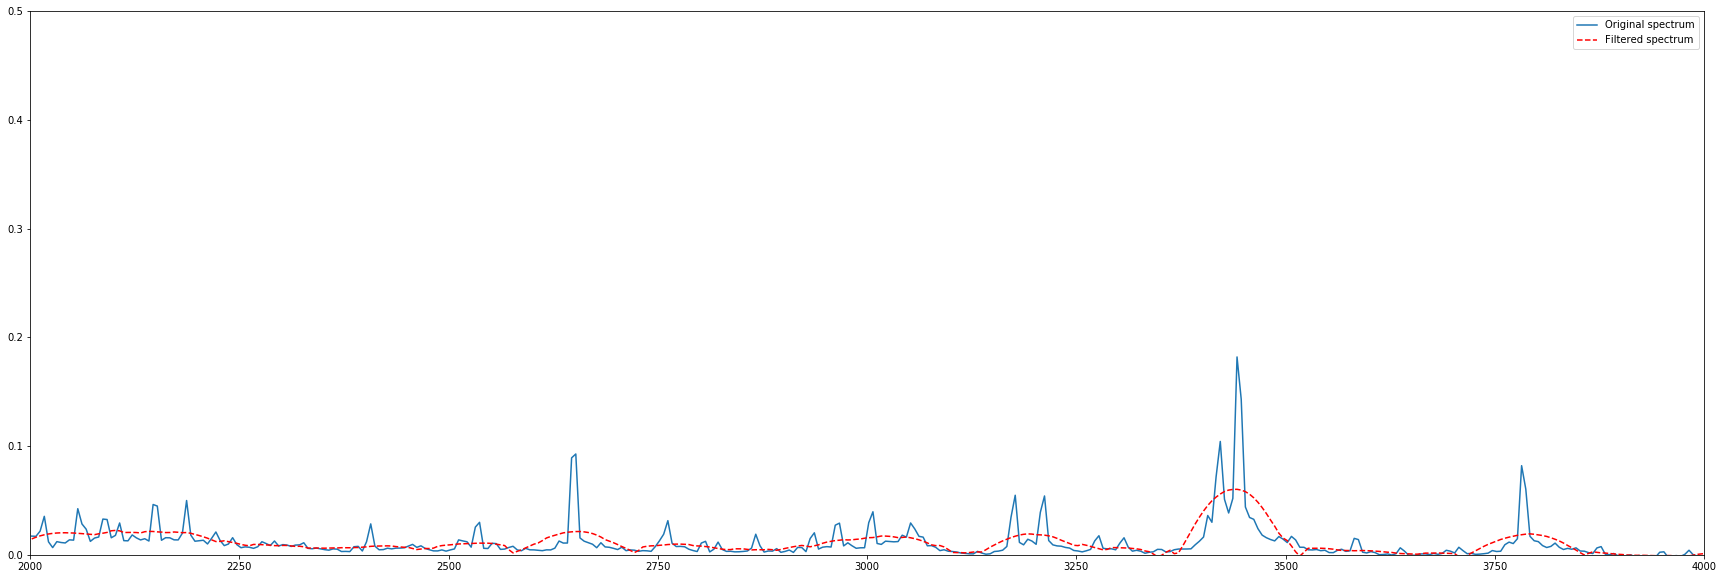

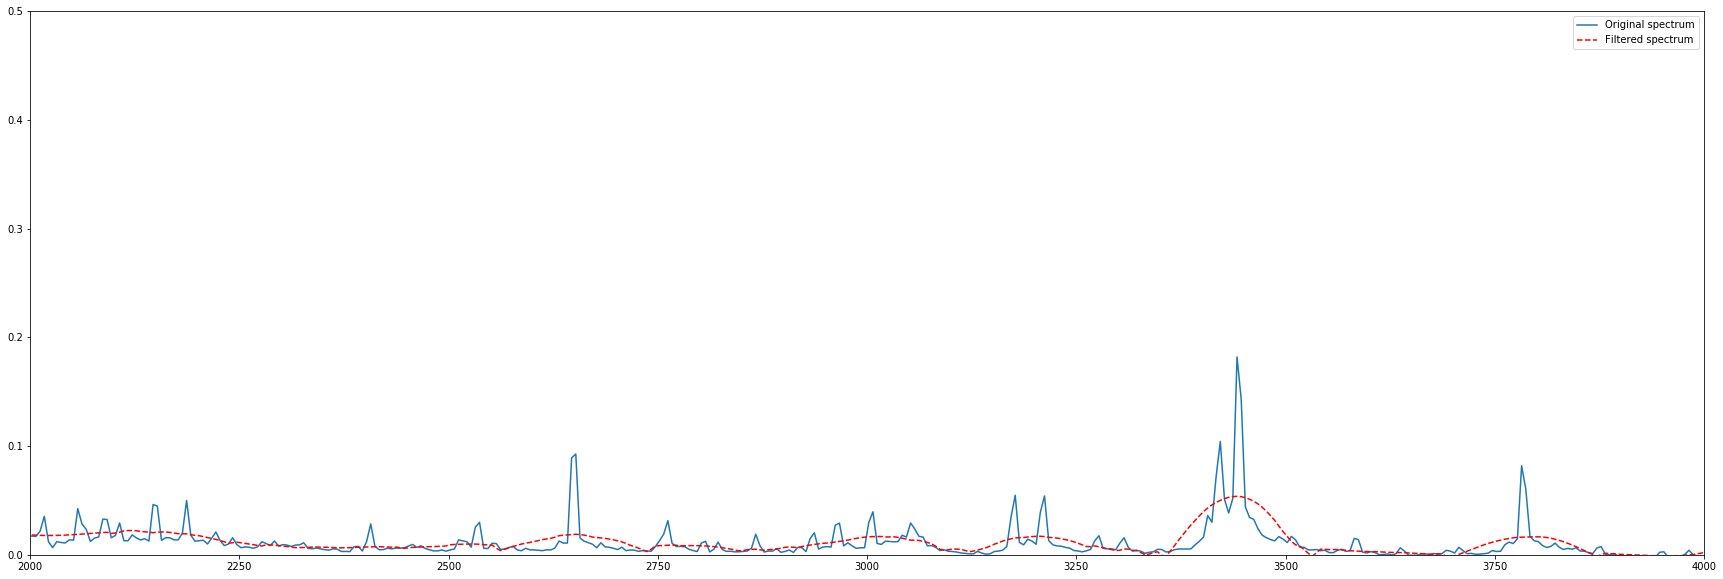

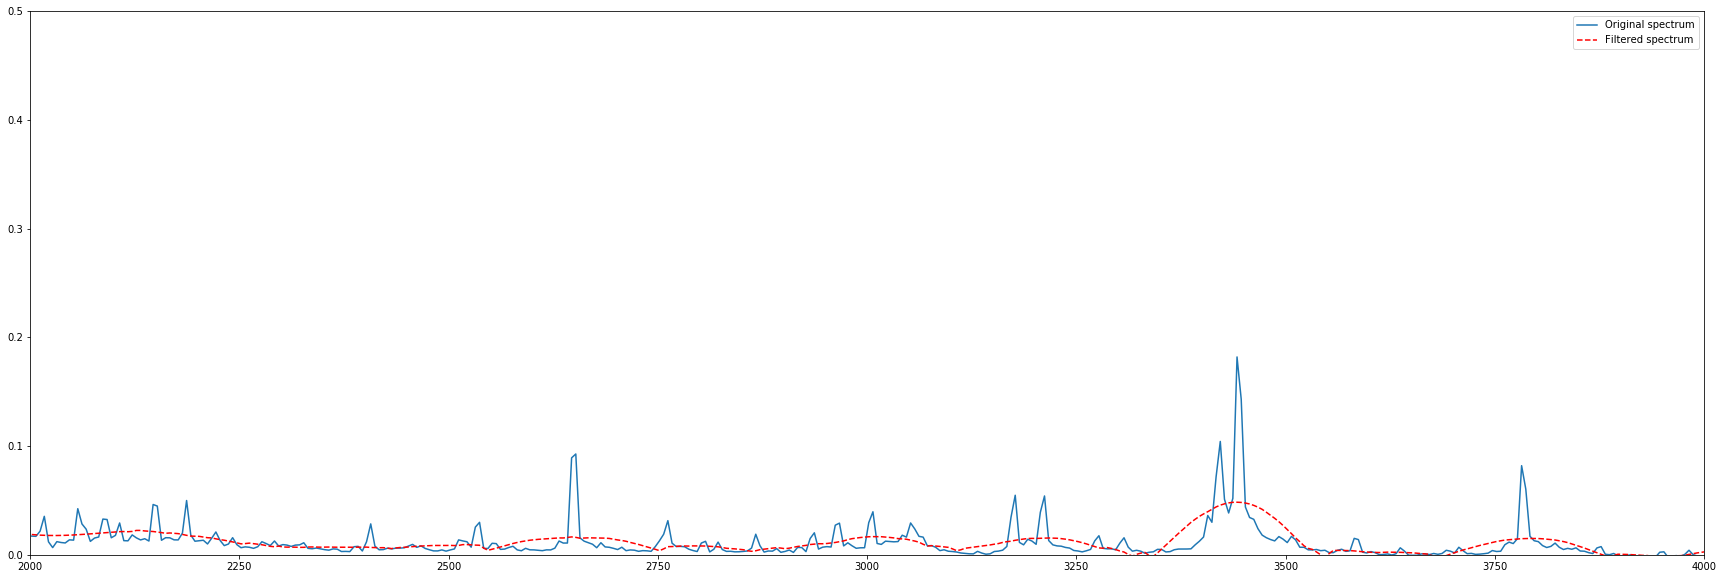

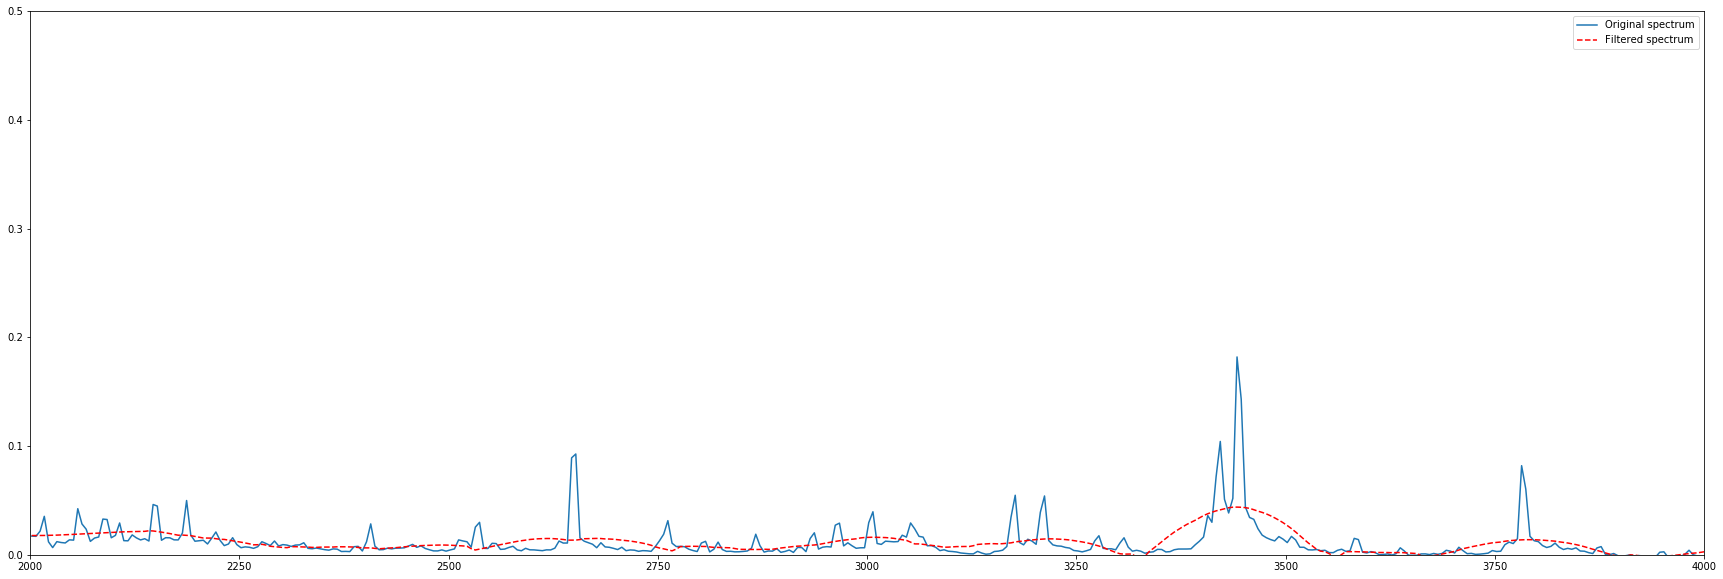

In [21]:
from scipy.signal import savgol_filter

for wl in np.arange(7,50,6):
    filt_spectrum = savgol_filter(mean_spectrum,window_length=wl,polyorder=3)
    plt.figure(figsize=(30,10))
    plt.plot(mz_axis,mean_spectrum,label='Original spectrum')
    plt.plot(mz_axis,filt_spectrum,'r--',label='Filtered spectrum'); 
    plt.xlim(2000,4000); plt.ylim(0,0.5); plt.legend(); plt.show()

W